<a href="https://colab.research.google.com/github/nv-hiep/Autoencoders/blob/main/Stacked_Autoencoders_Training_one_Autoencoder_at_a__Time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Reshape, Input
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, Dropout, ActivityRegularization
from keras.layers import LSTM, RepeatVector, TimeDistributed, GaussianNoise

In [3]:
def plot_image(image):
    plt.imshow(image, cmap='binary')
    # plt.axis('off')

# Data

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [5]:
X_train_full = X_train_full / 255.
X_test       = X_test / 255.

In [6]:
print('X_train_full.shape: ', X_train_full.shape)
print('y_train_full.shape: ', y_train_full.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train_full.shape:  (60000, 28, 28)
y_train_full.shape:  (60000,)
X_test.shape:  (10000, 28, 28)
y_test.shape:  (10000,)


In [7]:
train_size = 50_000

In [8]:
X_train = X_train_full[:train_size]
X_valid = X_train_full[train_size:]

y_train = y_train_full[:train_size]
y_valid = y_train_full[train_size:]

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_valid.shape: ', X_valid.shape)
print('y_valid.shape: ', y_valid.shape)

X_train.shape:  (50000, 28, 28)
y_train.shape:  (50000,)
X_valid.shape:  (10000, 28, 28)
y_valid.shape:  (10000,)


In [9]:
def show_reconstructions(model, images=X_test, n_images=5):
  '''
  First row: real images
  Second row: reconstructed images
  '''
  reconstructions = model.predict(images[:n_images])

  plt.figure(figsize=(n_images * 1.5, 3))
  for img_id in range(n_images):
    plt.subplot(2, n_images, 1 + img_id)
    plot_image(images[img_id])
    plt.subplot(2, n_images, 1 + n_images + img_id)
    plot_image(reconstructions[img_id])
  plt.show()

# Training one Autoencoder at a Time

It is possible to train one shallow autoencoder at a time, then stack all of them into a single stacked autoencoder.

During the first phase of training, the first autoencoder learns to reconstruct the inputs. Then we encode the whole training set using this first autoencoder, and this gives us a new (compressed) training set. We then train a second autoencoder on this new dataset. This is the second phase of training. Finally, we build a big sandwich using all these autoencoders

In [10]:
def train_autoencoder(n_neurons, X_train, X_valid,
                      loss_fcn, optimizer, n_epochs=10,
                      output_activation=None, metrics=None):
  
  n_inputs = X_train.shape[-1]

  encoder = Sequential()
  encoder.add( Dense(n_neurons, activation='selu', input_shape=[n_inputs]) )
  
  decoder = Sequential()
  decoder.add( Dense(n_inputs, activation=output_activation) )
  
  autoencoder = Sequential([encoder, decoder])

  autoencoder.compile(optimizer=optimizer, loss=loss_fcn, metrics=metrics)
  autoencoder.fit(X_train, X_train, epochs=n_epochs, validation_data=(X_valid, X_valid))

  return encoder, decoder, encoder(X_train), encoder(X_valid)

In [11]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)

enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(100,
                                                           X_train_flat,
                                                           X_valid_flat,
                                                           'binary_crossentropy',
                                                           SGD(learning_rate=1.5),
                                                           output_activation='sigmoid',
                                                           metrics=['binary_accuracy'])

enc2, dec2, _, _ = train_autoencoder(30,
                                     X_train_enc1,
                                     X_valid_enc1,
                                     'mse',
                                     SGD(learning_rate=0.05),
                                     output_activation='selu')

Epoch 1/10
1563/1563 [==============================] - 18s 3ms/step - loss: 0.4007 - binary_accuracy: 0.4881 - val_loss: 0.3132 - val_binary_accuracy: 0.5032
Epoch 2/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3082 - binary_accuracy: 0.5071 - val_loss: 0.3018 - val_binary_accuracy: 0.5046
Epoch 3/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2980 - binary_accuracy: 0.5084 - val_loss: 0.2947 - val_binary_accuracy: 0.5054
Epoch 4/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2913 - binary_accuracy: 0.5095 - val_loss: 0.2899 - val_binary_accuracy: 0.5058
Epoch 5/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2877 - binary_accuracy: 0.5088 - val_loss: 0.2866 - val_binary_accuracy: 0.5061
Epoch 6/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2843 - binary_accuracy: 0.5095 - val_loss: 0.2843 - val_binary_accuracy: 0.5063
Epoch 7/10
1563/1563 [=============================

Stack All the autoencoders

In [12]:
stacked_autoencoder = Sequential([
                                Flatten(input_shape=[28, 28]),
                                enc1, enc2,
                                dec2, dec1,
                                Reshape([28, 28])
                                ])

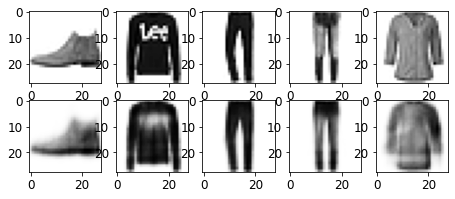

In [13]:
# Plot the reconstructed images
show_reconstructions(stacked_autoencoder, images=X_test)
plt.show()